### 주택 가격 예측 모델 (머신러닝)

#### 라이브러리 선언

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc("font", family = "Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn import set_config
set_config(display="text")
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, RobustScaler
from xgboost import XGBRegressor
from scipy.stats import spearmanr
import time
import pickle
import os

### 주택가격 예측모델 흐름 ppt 개요 만들기~

#### 전처리 이후 데이터 읽어들이기

In [2]:
df= pd.read_csv("./data/data_preprocessing.csv")
df

MSSubClass  MSZoning  LotFrontage  LotArea  Street  Alley  LotShape  \
0             60         3           65     8450       1      0         3   
1             20         3           80     9600       1      0         3   
2             60         3           68    11250       1      0         0   
3             70         3           60     9550       1      0         0   
4             60         3           84    14260       1      0         0   
...          ...       ...          ...      ...     ...    ...       ...   
1455          60         3           62     7917       1      0         3   
1456          20         3           85    13175       1      0         3   
1457          70         3           66     9042       1      0         3   
1458          20         3           68     9717       1      0         3   
1459          20         3           75     9937       1      0         3   

      LandContour  Utilities  LotConfig  ...  PoolArea  PoolQC  Fence  \
0               3          0          4  ...         0       0      0   
1               3          0          2  ...         0       0      0   
2               3          0          4  ...         0       0      0   
3               3          0          0  ...         0       0      0   
4               3          0          2  ...         0       0      0   
...           ...        ...        ...  ...       ...     ...    ...   
1455            3          0          4  ...         0       0      0   
1456            3          0          4  ...         0       0      3   
1457            3          0          4  ...         0       0      4   
1458            3          0          4  ...         0       0      0   
1459            3          0          4  ...         0       0      0   

      MiscFeature  MiscVal  MoSold  YrSold  SaleType  SaleCondition  SalePrice  
0               0        0       2    2008         8              4     208500  
1               0        0       5    2007         8              4     181500  
2               0        0       9    2008         8              4     223500  
3               0        0       2    2006         8              0     140000  
4               0        0      12    2008         8              4     250000  
...           ...      ...     ...     ...       ...            ...        ...  
1455            0        0       8    2007         8              4     175000  
1456            0        0       2    2010         8              4     210000  
1457            1     2500       5    2010         8              4     266500  
1458            0        0       4    2010         8              4     142125  
1459            0        0       6    2008         8              4     147500  

[1460 rows x 80 columns]

### 데이터분리

In [3]:
### 종속변수, 독립변수 분리
# 독립변수 금액을 제외한 모든 컬럼
# 종속변수 금액

x = df.iloc[:,:-1]
y = df["SalePrice"]
print(x.shape, y.shape)

(1460, 79) (1460,)


In [4]:
### 훈련 : 테스트 // 6:2:2
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(1168, 79) (1168,)
(146, 79) (146,)
(146, 79) (146,)


### 모델정의

In [5]:
lr  = LinearRegression()
rd  = Ridge()
ls = Lasso()
rf  = RandomForestRegressor()
ext = ExtraTreesRegressor()
gb  = GradientBoostingRegressor()
hgb = HistGradientBoostingRegressor()
xgb = XGBRegressor()

models = [lr, rd, ls, rf, ext, gb, hgb, xgb]
models

[LinearRegression(),
 Ridge(),
 Lasso(),
 RandomForestRegressor(),
 ExtraTreesRegressor(),
 GradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)]

### 기본모델 훈련하기

In [26]:
for model in models:
    model_name = model.__class__.__name__

    model.fit(x_train, y_train)

    # 모델 점수
    train_score = model.score(x_train, y_train)
    val_score = model.score(x_val, y_val)
    test_score = model.score(x_test, y_test)

    # 예측 값 계산
    train_pred = model.predict(x_train)
    val_pred = model.predict(x_val)
    test_pred = model.predict(x_test)

    # 평가 지표
    train_mae = mean_absolute_error(y_train, train_pred)
    val_mae = mean_absolute_error(y_val, val_pred)
    test_mae = mean_absolute_error(y_test, test_pred)

    train_mse = mean_squared_error(y_train, train_pred)
    val_mse = mean_squared_error(y_val, val_pred)
    test_mse = mean_squared_error(y_test, test_pred)

    train_r2 = r2_score(y_train, train_pred)
    val_r2 = r2_score(y_val, val_pred)
    test_r2 = r2_score(y_test, test_pred)

    # 결과 출력
    print(f"---- {model_name} ----")
    print(f"과적합 여부: {train_score - val_score:.4f}")
    print(f"훈련 MAE: {train_mae:.4f}, 검증 MAE: {test_mae:.4f}, 테스트 MAE: {test_mae:.4f}")
    print(f"훈련 MSE: {train_mse:.4f}, 검증 MSE: {val_mse:.4f}, 테스트 MSE: {test_mse:.4f}")
    print(f"훈련 R²: {train_r2:.4f}, 검증 R²: {val_r2:.4f},  테스트 R²: {test_r2:.4f}")
    print("=" * 50)

---- LinearRegression ----
과적합 여부: -0.0405
훈련 MAE: 19003.6647, 검증 MAE: 22959.1351, 테스트 MAE: 22959.1351
훈련 MSE: 931633756.3199, 검증 MSE: 677925892.5599, 테스트 MSE: 1622173379.8210
훈련 R²: 0.8438, 검증 R²: 0.8843,  테스트 R²: 0.8276
---- Ridge ----
과적합 여부: -0.0411
훈련 MAE: 18994.6934, 검증 MAE: 22902.5879, 테스트 MAE: 22902.5879
훈련 MSE: 932502156.5588, 검증 MSE: 674871315.3328, 테스트 MSE: 1620099165.1757
훈련 R²: 0.8437, 검증 R²: 0.8848,  테스트 R²: 0.8278
---- Lasso ----
과적합 여부: -0.0405
훈련 MAE: 19001.1175, 검증 MAE: 22954.2477, 테스트 MAE: 22954.2477
훈련 MSE: 931635589.2050, 검증 MSE: 677714545.6771, 테스트 MSE: 1622008706.9513
훈련 R²: 0.8438, 검증 R²: 0.8843,  테스트 R²: 0.8276
---- RandomForestRegressor ----
과적합 여부: 0.0749
훈련 MAE: 6477.0634, 검증 MAE: 19157.2718, 테스트 MAE: 19157.2718
훈련 MSE: 119509699.2913, 검증 MSE: 556486832.8380, 테스트 MSE: 1053353930.6496
훈련 R²: 0.9800, 검증 R²: 0.9050,  테스트 R²: 0.8880
---- ExtraTreesRegressor ----
과적합 여부: 0.0821
훈련 MAE: 0.0000, 검증 MAE: 18984.7740, 테스트 MAE: 18984.7740
훈련 MSE: 0.0000, 검증 MSE: 480828

In [ ]:
"""
<기본 모델 해석>
- 주택가격을 예측하기 위하여 8개의 모델로 훈련 평가를 수행한 결과는 위와 같다.
 -- 훈련 결정계수가 1.0으로 나타난 모델은 1개 (ExtraTreesRegressor), 과대 적합이 발생한 모델은 1개 (XGBRegressor)로 보이며
 -- 과소적합이 발생한 모델은 3개(LinearRegression), (Ridge), (Lasso)이다 이를 제외한 모델은 일반화가 잘된 것으로 판단된다.
 -- 각 모델들의 훈련 결정계수의 범위는 0.84 ~ 1.0 사이로 매우 훌륭한 모델이며 그 중 아래 모델이 최고의 모델로 선정하였다.

---- GradientBoostingRegressor ----
과적합 여부: 0.0607
훈련 MAE: 9847.2682, 검증 MAE: 19130.9140, 테스트 MAE: 19130.9140
훈련 MSE: 179748895.9204, 검증 MSE: 532275369.1167, 테스트 MSE: 1108290869.5452
훈련 R²: 0.9699, 검증 R²: 0.9091,  테스트 R²: 0.8822

훈련 R²이 0.9699 매우 훌륭한 모델이 도출되었으나 검증R²값이 상대적으로 낮아
검증R²를 높일 수 있는 방법을 모색해야 봐야할 것으로 판단됨
검증R²를 높이기 위해 스케일링, 하이퍼파라메터 수정을 선행해야할 것으로 판단됨
또한 과소적합을 비롯한 일반화가 잘 되지 않은 모델들이 많아 위와 같은 수정이 필요할 것으로 판단됨 
"""

'\n<기본 모델 해석>\n- 주택가격을 예측하기 위하여 8개의 모델로 훈련 평가를 수행한 결과는 위와 같다.\n -- 과대적합이 발생한 모델은 2개(HistGradientBoostingRegressor , ExtraTreesRegressor)이고, 그 외 6개의 모델은 일반화가 잘된 것으로 나타남\n -- 각 모델들의 훈련 결정계수의 범위는 0.84 ~ 1.0 사이로 매우 훌륭한 모델이며 그 중 아래 모델이 최고의 모델로 선정하였다.\n\n---- XGBRegressor ----\n과적합 여부: 0.0821\n훈련 MAE: 656.0961, 검증 MAE: 18082.0161, 테스트 MAE: 18082.0161\n훈련 MSE: 899203.6555, 검증 MSE: 551382406.9169, 테스트 MSE: 773861925.7549\n훈련 R²: 0.9998, 검증 R²: 0.9059,  테스트 R²: 0.9178\n\n훈련 R²이 0.9998로 매우 훌륭한 모델이 도출되었으나 검증R²값이 상대적으로 낮아\n검증R²를 높일 수 있는 방법을 모색해야 봐야할 것으로 판단됨\n검증R²를 높이기 위해 스케일링, 하이퍼파라메터 수정을 선행해야할 것으로 판단됨\n'

### 전처리 이후 하이퍼파라메터 수정, 스케일링 모델 돌려보기

In [27]:
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)
rs_df = pd.DataFrame()
for degree in range(1,2):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly.fit(x_train)

    train_poly = poly.transform(x_train)
    val_poly = poly.transform(x_val)
    test_poly = poly.transform(x_test)
    scalers = {"StandardScaler": StandardScaler(),
        "MinMaxScaler": MinMaxScaler(),
        "RobustScaler": RobustScaler(),
        "No Scaling": None}

for scaler_name, scaler in scalers.items():
    if scaler:
        train_scaled = scaler.fit_transform(train_poly)
        val_scaled = scaler.transform(val_poly)
        test_scaled = scaler.transform(test_poly)
    else:
        train_scaled = x_train
        val_scaled = x_val
        test_scaled = x_test

    for model in models:
        model_nm = model.__class__.__name__
        start_time = time.time()
        for idx in range(0,2):
            if idx == 0 :
                param_grid = {
                    "LinearRegression": {},
                    "Ridge": {"alpha": [0.1, 1, 10, 100], "max_iter": [5000, 10000]},
                    "Lasso": {"alpha": [0.1, 1, 10, 100], "max_iter": [5000, 10000]},
                    "RandomForestRegressor": {"n_estimators": [50, 100, 200], "max_depth": [5, 10, 15], "min_samples_split": [2, 5]},
                    "ExtraTreesRegressor": {"n_estimators": [50, 100, 200], "max_depth": [5, 10, 15], "min_samples_split": [2, 5]},
                    "GradientBoostingRegressor": {"n_estimators": [50, 100, 200],"learning_rate": [0.01, 0.1, 0.2], "max_depth": [3, 5, 7]},
                    "HistGradientBoostingRegressor": {"max_iter": [50, 100, 200], "learning_rate": [0.01, 0.1], "max_depth": [3, 5]},
                    "XGBRegressor": {"n_estimators": [50, 100, 200],"max_depth": [3, 5, 7], "learning_rate": [0.01, 0.1], "min_child_weight": [1, 2]},
                }.get(model_nm, {})  # 딕셔너리 키를 찾아 값 반환 (하이퍼파라메터값)

            else :
                param_grid = {}
            default_model = model.__class__()  # 기본 모델 생성
            default_model.fit(train_scaled, y_train)
            default_train_pred = default_model.predict(train_scaled)
            default_val_pred = default_model.predict(val_scaled)

            # 기본 모델 평가 점수 계산
            default_train_r2 = round(r2_score(y_train, default_train_pred), 4)
            default_val_r2 = round(r2_score(y_val, default_val_pred), 4)
            default_train_val_diff = round(default_train_r2 - default_val_r2, 4)


            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grid,
                scoring="r2",
                refit=True, # 가장 좋은 하이퍼파라메터를 저장
                cv=5,
                n_jobs=-1)

            grid_search.fit(train_scaled, y_train)
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_
            
            ### 모델 저장    
            model_filename = f"{save_dir}/{model_nm}_{scaler_name}_best.pkl"
            with open(model_filename, "wb") as f:
                    pickle.dump(best_model, f)

            print(f"🔹 최적 모델 저장 완료: {model_filename}")
            
            
            train_pred = best_model.predict(train_scaled)
            val_pred = best_model.predict(val_scaled)
            test_pred = best_model.predict(test_scaled)

            train_mae = round(mean_absolute_error(y_train, train_pred), 4)
            train_mse = round(mean_squared_error(y_train, train_pred), 4)
            train_r2 = round(r2_score(y_train, train_pred), 4)
            
            val_mae = round(mean_absolute_error(y_val, val_pred), 4)
            val_mse = round(mean_squared_error(y_val, val_pred), 4)
            val_r2 = round(r2_score(y_val, val_pred), 4)
            
            test_mae = round(mean_absolute_error(y_test, test_pred), 4)
            test_mse = round(mean_squared_error(y_test, test_pred), 4)
            test_r2 = round(r2_score(y_test, test_pred), 4)
            train_val_diff = round(train_r2 - val_r2, 4)

            msg = (f"모델명: {model_nm}, 사용된 스케일러: {scaler_name}"
                f" 최적 하이퍼파라미터: {best_params}\n"
                f"훈련MAE: {train_mae:.4f}, 훈련MSE: {train_mse:.4f}, 훈련R2: {train_r2:.4f}\n"
                f"검증MAE: {val_mae:.4f}, 검증MSE: {val_mse:.4f}, 검증R2: {val_r2:.4f}\n"
                f"테스트MAE: {test_mae:.4f}, 테스트MSE: {test_mse:.4f}, 테스트R2: {test_r2:.4f}\n"
                f"과적합여부(R2 차이): {train_val_diff:.4f}")
            print(msg, "\n")
            print("===================================")
            if (train_r2 != 1) & (train_val_diff < 0.1):
                df_data = pd.DataFrame([[model_nm, degree, scaler_name, best_params, train_mse, val_mse, test_mse,
                                        train_r2, val_r2, test_r2, train_val_diff]],
                                        columns=["모델명","특성공학","스케일링", "하이퍼파라메터_튜닝", "훈련MSE", "검증MSE","테스트MSE",
                                                "훈련R2", "검증R2","테스트R2", "과적합여부"])
                rs_df = pd.concat([rs_df, df_data], ignore_index=True)
                end_time = time.time()
                elapsed_time = end_time - start_time

        print(f"모델 학습 소요 시간: {elapsed_time:.2f}초")
        print(f"start_time:{start_time}\n")
# 특성공학 : 1  하이퍼 파라메터_튜닝은 : 베스트로 기재될 예정입니다.

🔹 최적 모델 저장 완료: saved_models/LinearRegression_StandardScaler_best.pkl
모델명: LinearRegression, 사용된 스케일러: StandardScaler 최적 하이퍼파라미터: {}
훈련MAE: 19003.7184, 훈련MSE: 931610011.3391, 훈련R2: 0.8438
검증MAE: 19877.6009, 검증MSE: 677795814.4206, 검증R2: 0.8843
테스트MAE: 22962.5340, 테스트MSE: 1620500550.9756, 테스트R2: 0.8278
과적합여부(R2 차이): -0.0405 

🔹 최적 모델 저장 완료: saved_models/LinearRegression_StandardScaler_best.pkl
모델명: LinearRegression, 사용된 스케일러: StandardScaler 최적 하이퍼파라미터: {}
훈련MAE: 19003.7184, 훈련MSE: 931610011.3391, 훈련R2: 0.8438
검증MAE: 19877.6009, 검증MSE: 677795814.4206, 검증R2: 0.8843
테스트MAE: 22962.5340, 테스트MSE: 1620500550.9756, 테스트R2: 0.8278
과적합여부(R2 차이): -0.0405 

모델 학습 소요 시간: 4.28초
start_time:1742782532.9162042

🔹 최적 모델 저장 완료: saved_models/Ridge_StandardScaler_best.pkl
모델명: Ridge, 사용된 스케일러: StandardScaler 최적 하이퍼파라미터: {'alpha': 100, 'max_iter': 5000}
훈련MAE: 18728.5328, 훈련MSE: 947173774.5389, 훈련R2: 0.8412
검증MAE: 19184.8801, 검증MSE: 648496478.5713, 검증R2: 0.8893
테스트MAE: 22391.4858, 테스트MSE: 1627312804.5323, 테스트R2

c:\Users\Administrator\anaconda3\envs\pk_dl_202503\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.801e+09, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(


🔹 최적 모델 저장 완료: saved_models/Lasso_StandardScaler_best.pkl
모델명: Lasso, 사용된 스케일러: StandardScaler 최적 하이퍼파라미터: {'alpha': 100, 'max_iter': 5000}
훈련MAE: 18865.8776, 훈련MSE: 933352765.8685, 훈련R2: 0.8435
검증MAE: 19680.7226, 검증MSE: 662006870.2364, 검증R2: 0.8870
테스트MAE: 22738.5751, 테스트MSE: 1620490484.9558, 테스트R2: 0.8278
과적합여부(R2 차이): -0.0435 

🔹 최적 모델 저장 완료: saved_models/Lasso_StandardScaler_best.pkl
모델명: Lasso, 사용된 스케일러: StandardScaler 최적 하이퍼파라미터: {}
훈련MAE: 19001.3449, 훈련MSE: 931633982.2601, 훈련R2: 0.8438
검증MAE: 19882.1598, 검증MSE: 677742838.4306, 검증R2: 0.8843
테스트MAE: 22956.0979, 테스트MSE: 1622092569.3093, 테스트R2: 0.8276
과적합여부(R2 차이): -0.0405 

모델 학습 소요 시간: 0.59초
start_time:1742782538.1552975



c:\Users\Administrator\anaconda3\envs\pk_dl_202503\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.801e+09, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\Administrator\anaconda3\envs\pk_dl_202503\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.801e+09, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(


🔹 최적 모델 저장 완료: saved_models/RandomForestRegressor_StandardScaler_best.pkl
모델명: RandomForestRegressor, 사용된 스케일러: StandardScaler 최적 하이퍼파라미터: {'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 100}
훈련MAE: 7280.5247, 훈련MSE: 168772289.1390, 훈련R2: 0.9717
검증MAE: 15316.0318, 검증MSE: 532395439.1958, 검증R2: 0.9091
테스트MAE: 19891.8600, 테스트MSE: 1134269666.1979, 테스트R2: 0.8794
과적합여부(R2 차이): 0.0626 

🔹 최적 모델 저장 완료: saved_models/RandomForestRegressor_StandardScaler_best.pkl
모델명: RandomForestRegressor, 사용된 스케일러: StandardScaler 최적 하이퍼파라미터: {}
훈련MAE: 6684.6952, 훈련MSE: 136779663.3131, 훈련R2: 0.9771
검증MAE: 15428.5284, 검증MSE: 551071549.7505, 검증R2: 0.9059
테스트MAE: 19770.7879, 테스트MSE: 1141766859.0256, 테스트R2: 0.8787
과적합여부(R2 차이): 0.0712 

모델 학습 소요 시간: 13.96초
start_time:1742782538.7494013

🔹 최적 모델 저장 완료: saved_models/ExtraTreesRegressor_StandardScaler_best.pkl
모델명: ExtraTreesRegressor, 사용된 스케일러: StandardScaler 최적 하이퍼파라미터: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 100}
훈련MAE: 753.3275, 훈련MSE: 1

c:\Users\Administrator\anaconda3\envs\pk_dl_202503\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.129e+11, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(


🔹 최적 모델 저장 완료: saved_models/Lasso_RobustScaler_best.pkl
모델명: Lasso, 사용된 스케일러: RobustScaler 최적 하이퍼파라미터: {'alpha': 100, 'max_iter': 5000}
훈련MAE: 18826.3488, 훈련MSE: 938723642.7363, 훈련R2: 0.8426
검증MAE: 19625.9120, 검증MSE: 652954326.5062, 검증R2: 0.8885
테스트MAE: 22622.6689, 테스트MSE: 1624496946.8616, 테스트R2: 0.8273
과적합여부(R2 차이): -0.0459 

🔹 최적 모델 저장 완료: saved_models/Lasso_RobustScaler_best.pkl
모델명: Lasso, 사용된 스케일러: RobustScaler 최적 하이퍼파라미터: {}
훈련MAE: 19000.5951, 훈련MSE: 931635756.8236, 훈련R2: 0.8438
검증MAE: 19881.9193, 검증MSE: 677600555.1314, 검증R2: 0.8843
테스트MAE: 22954.4534, 테스트MSE: 1622126601.2018, 테스트R2: 0.8276
과적합여부(R2 차이): -0.0405 

모델 학습 소요 시간: 0.78초
start_time:1742782629.2801187



c:\Users\Administrator\anaconda3\envs\pk_dl_202503\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.129e+11, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\Administrator\anaconda3\envs\pk_dl_202503\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.129e+11, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(


🔹 최적 모델 저장 완료: saved_models/RandomForestRegressor_RobustScaler_best.pkl
모델명: RandomForestRegressor, 사용된 스케일러: RobustScaler 최적 하이퍼파라미터: {'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 200}
훈련MAE: 7213.2534, 훈련MSE: 157972919.0196, 훈련R2: 0.9735
검증MAE: 15258.2518, 검증MSE: 523968249.1515, 검증R2: 0.9106
테스트MAE: 19692.2671, 테스트MSE: 1100204152.3156, 테스트R2: 0.8831
과적합여부(R2 차이): 0.0629 

🔹 최적 모델 저장 완료: saved_models/RandomForestRegressor_RobustScaler_best.pkl
모델명: RandomForestRegressor, 사용된 스케일러: RobustScaler 최적 하이퍼파라미터: {}
훈련MAE: 6547.7155, 훈련MSE: 143848801.1993, 훈련R2: 0.9759
검증MAE: 14967.5276, 검증MSE: 536806758.8382, 검증R2: 0.9084
테스트MAE: 20261.3466, 테스트MSE: 1196261155.7942, 테스트R2: 0.8729
과적합여부(R2 차이): 0.0675 

모델 학습 소요 시간: 15.24초
start_time:1742782630.0618565

🔹 최적 모델 저장 완료: saved_models/ExtraTreesRegressor_RobustScaler_best.pkl
모델명: ExtraTreesRegressor, 사용된 스케일러: RobustScaler 최적 하이퍼파라미터: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 50}
훈련MAE: 884.2629, 훈련MSE: 2123743.7359, 

### 최적의 모델 찾기

In [28]:
rs_df_train_r2= rs_df.sort_values("훈련R2", ascending=False)
rs_df_train_r2.head(10)

모델명  특성공학            스케일링  \
8             ExtraTreesRegressor     1  StandardScaler   
36            ExtraTreesRegressor     1    RobustScaler   
23      GradientBoostingRegressor     1    MinMaxScaler   
51      GradientBoostingRegressor     1      No Scaling   
22            ExtraTreesRegressor     1    MinMaxScaler   
50            ExtraTreesRegressor     1      No Scaling   
37      GradientBoostingRegressor     1    RobustScaler   
9       GradientBoostingRegressor     1  StandardScaler   
21          RandomForestRegressor     1    MinMaxScaler   
12  HistGradientBoostingRegressor     1  StandardScaler   

                                           하이퍼파라메터_튜닝         훈련MSE  \
8   {'max_depth': 15, 'min_samples_split': 2, 'n_e...  1.544182e+06   
36  {'max_depth': 15, 'min_samples_split': 2, 'n_e...  2.123744e+06   
23  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...  1.419421e+07   
51  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...  1.419421e+07   
22  {'max_depth': 15, 'min_samples_split': 5, 'n_e...  1.733420e+07   
50  {'max_depth': 10, 'min_samples_split': 2, 'n_e...  5.819051e+07   
37  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  1.029216e+08   
9   {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  1.029216e+08   
21                                                 {}  1.210948e+08   
12                                                 {}  1.270430e+08   

           검증MSE        테스트MSE    훈련R2    검증R2   테스트R2   과적합여부  
8   5.000494e+08  1.217405e+09  0.9997  0.9146  0.8706  0.0851  
36  5.088287e+08  1.274962e+09  0.9996  0.9131  0.8645  0.0865  
23  4.655700e+08  7.937480e+08  0.9976  0.9205  0.9156  0.0771  
51  4.635216e+08  7.766696e+08  0.9976  0.9209  0.9175  0.0767  
22  4.302546e+08  1.281538e+09  0.9971  0.9266  0.8638  0.0705  
50  4.876586e+08  1.243219e+09  0.9902  0.9168  0.8679  0.0734  
37  4.964128e+08  1.099903e+09  0.9827  0.9153  0.8831  0.0674  
9   5.070529e+08  1.053585e+09  0.9827  0.9135  0.8880  0.0692  
21  5.489735e+08  1.061871e+09  0.9797  0.9063  0.8871  0.0734  
12  5.170035e+08  1.119222e+09  0.9787  0.9118  0.8810  0.0669

In [30]:
save_path = "./data/dt.xlsx"
rs_df_train_r2.to_excel(save_path, index=False)

In [ ]:
"""
<해석>
기본 모델중 성능이 가장 좋은 모델 GradientBoostingRegressor : 훈련 R²: 0.9699, 검증 R²: 0.9091, 테스트 R²: 0.8822, 과적합 여부: 0.0607


===모델 성능 개선 후 가장 좋은 모델====
모델명: GradientBoostingRegressor, 사용된 스케일러: MinMaxScaler 최적 하이퍼파라미터: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
훈련R2: 0.9976, 검증R2: 0.9205, 테스트R2: 0.9156, 과적합여부(R2 차이): 0.0771 

튜닝 후 과적합이 근소하게 증가하였지만 훈련결정계수를 비롯하여 검증, 테스트 결정계수가 증가하여 해당 모델로 선정하였음.
따라서 검증 성능을 고려하면 튜닝된 GradientBoostingRegressor 더 뛰어난 성능의 모델로 판단됨

다만 결측치처리 이후의 상관관계가 궁금했고, 
상관관계가 낮은 것들이 특성중요도도 낮을까라는 의문이 생겨 각 상관관계, 특성중요도를 도출하여
비교하는 작업을 진행해 볼 예정입니다.

<진행과정>
상관관계(Spearmanr)가 높은 특성이 특성 중요도도 높은지 확인
상관관계가 낮은 특성이 특성 중요도도 낮은지 확인

데이터가 비선형 관계를 가질 때도 있기에 스피어만 상관계수로 확인
스피어만 상관분석 + P-value 필터링
P-value를 이용해 유의하지 않은 변수(의미 없는 변수) 제거
선택된 변수만 사용하여 모델을 다시 학습

특성 중요도 비교 분석
상관관계과 특성중요도에서의 영향을 미치는 컬럼들이 같은지 비교

상관관계는 낮지만 특성 중요도가 높은 변수 또는 그 반대의 경우 탐색
결론적으로, 상관관계가 높은 변수가 특성 중요도도 높은지, 그리고 상관관계가 낮은 변수가 특성 중요도도 낮은지 실제로 확인 예정
"""

"\n<해석>\n기본 모델중 성능이 가장 좋은 모델 XGBRegressor : 훈련 R²: 0.9998, 검증 R²: 0.9059, 테스트 R²: 0.9178, 과적합 여부: 0.0821\n\n===모델 성능 개선 후 가장 좋은 모델====\n모델명: ExtraTreesRegressor, 사용된 스케일러: MinMaxScaler 최적 하이퍼파라미터: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 100}\n훈련R2: 0.9997, 검증R2: 0.9216, 테스트R2: 0.8550, 과적합여부(R2 차이): 0.0781 \n\n튜닝 후 과적합이 0.0781로 줄어들었으며 모델의 일반화 성능이 더 좋아짐을 확인하였지만 다만 테스트 성능은 조금 감소하였다\n따라서 검증 성능을 고려하면 튜닝된 ExtraTreesRegressor가 더 안정적인 모델로 판단됨\n\n다만 결측치처리 이후의 상관관계가 궁금했고, \n상관관계가 낮은 것들이 특성중요도도 낮을까라는 의문이 생겨 각 상관관계, 특성중요도를 도출하여\n비교하는 작업을 진행해 볼 예정입니다.\n\n<진행과정>\n상관관계(Spearmanr)가 높은 특성이 특성 중요도도 높은지 확인\n상관관계가 낮은 특성이 특성 중요도도 낮은지 확인\n\n데이터가 비선형 관계를 가질 때도 있기에 스피어만 상관계수로 확인\n스피어만 상관분석 + P-value 필터링\nP-value를 이용해 유의하지 않은 변수(의미 없는 변수) 제거\n선택된 변수만 사용하여 모델을 다시 학습\n\n특성 중요도 비교 분석\n상관관계과 특성중요도에서의 영향을 미치는 컬럼들이 같은지 비교\n\n상관관계는 낮지만 특성 중요도가 높은 변수 또는 그 반대의 경우 탐색\n결론적으로, 상관관계가 높은 변수가 특성 중요도도 높은지, 그리고 상관관계가 낮은 변수가 특성 중요도도 낮은지 실제로 확인 예정\n"

### EDA를 통한 상관관계 확인 및 시각화

<Axes: title={'center': '주택특성들 간 금액 예측(상관관계 매트릭스)'}>

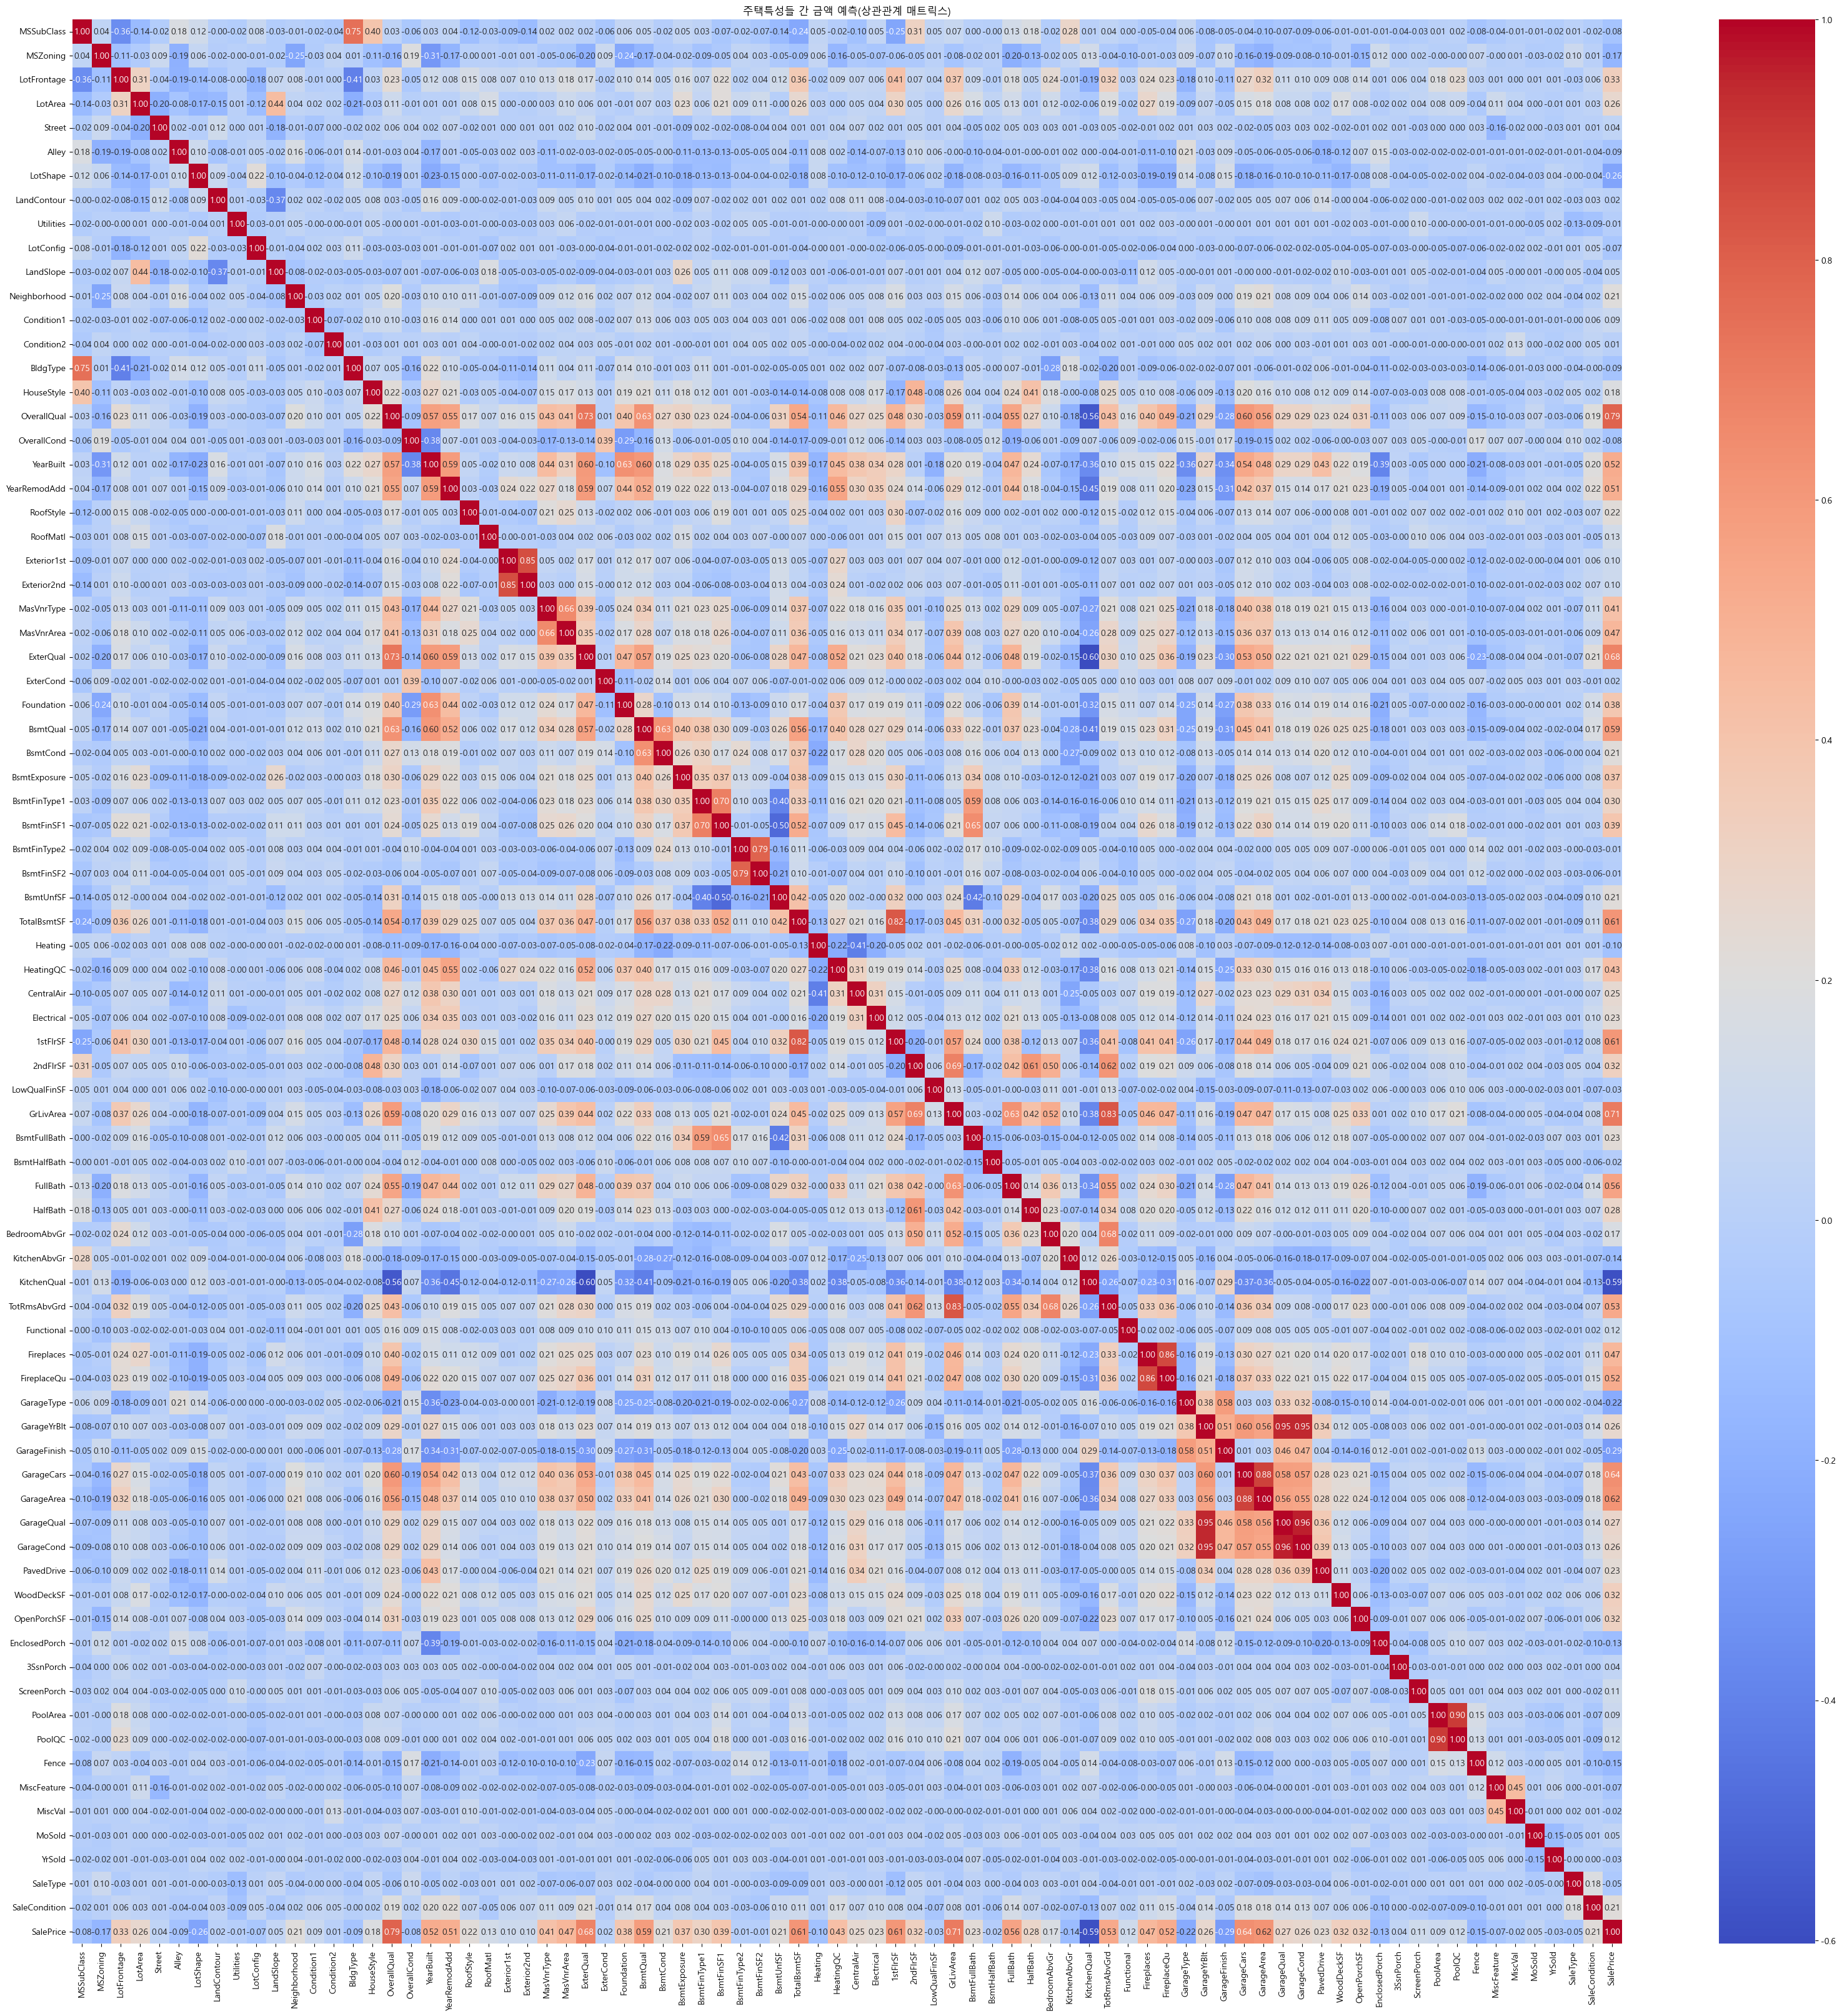

In [11]:
# 상관관계 
cr = df.corr()
# cr
plt.figure(figsize=(40, 40))  # 그래프 크기 조정
plt.title("주택특성들 간 금액 예측(상관관계 매트릭스)")
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")


### 전처리 이후 상관계수 도출

In [12]:
# ### 종속변수, 독립변수 분리
# x = df.iloc[:,:-1]
# y = df["SalePrice"]
# print(x.shape, y.shape)
# 위에서 정의되어 있지만 확인차

correlation_matrix = df.corr()
# correlation_matrix
saleprice_corr = correlation_matrix["SalePrice"].abs()
saleprice_corr.sort_values(ascending=True)

BsmtFinType2    0.005323
Condition2      0.007513
BsmtFinSF2      0.011378
Utilities       0.014314
LandContour     0.015453
                  ...   
GarageCars      0.640409
ExterQual       0.682639
GrLivArea       0.708624
OverallQual     0.790982
SalePrice       1.000000
Name: SalePrice, Length: 80, dtype: float64

### 전처리 이후 특성중요도 도출

In [13]:
### 종속변수, 독립변수 분리
x = df.iloc[:,:-1]
y = df["SalePrice"]
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(1168, 79) (1168,)
(146, 79) (146,)
(146, 79) (146,)


In [14]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(x_train, y_train)

y_pred = rf_model.predict(x_val)

mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Val MSE: {mse:.4f}")
print(f"Val R² Score: {r2:.4f}")

# 특성 중요도
feature_importance = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# 특성 중요도 출력
print(feature_importance)

Val MSE: 522791700.3006
Val R² Score: 0.9108
         Feature  Importance
16   OverallQual    0.555236
45     GrLivArea    0.120953
43      2ndFlrSF    0.034469
37   TotalBsmtSF    0.033958
33    BsmtFinSF1    0.028072
..           ...         ...
44  LowQualFinSF    0.000056
73   MiscFeature    0.000036
74       MiscVal    0.000033
4         Street    0.000003
8      Utilities    0.000000

[79 rows x 2 columns]


### 스피어만 상관계수에서 상관계수 도출

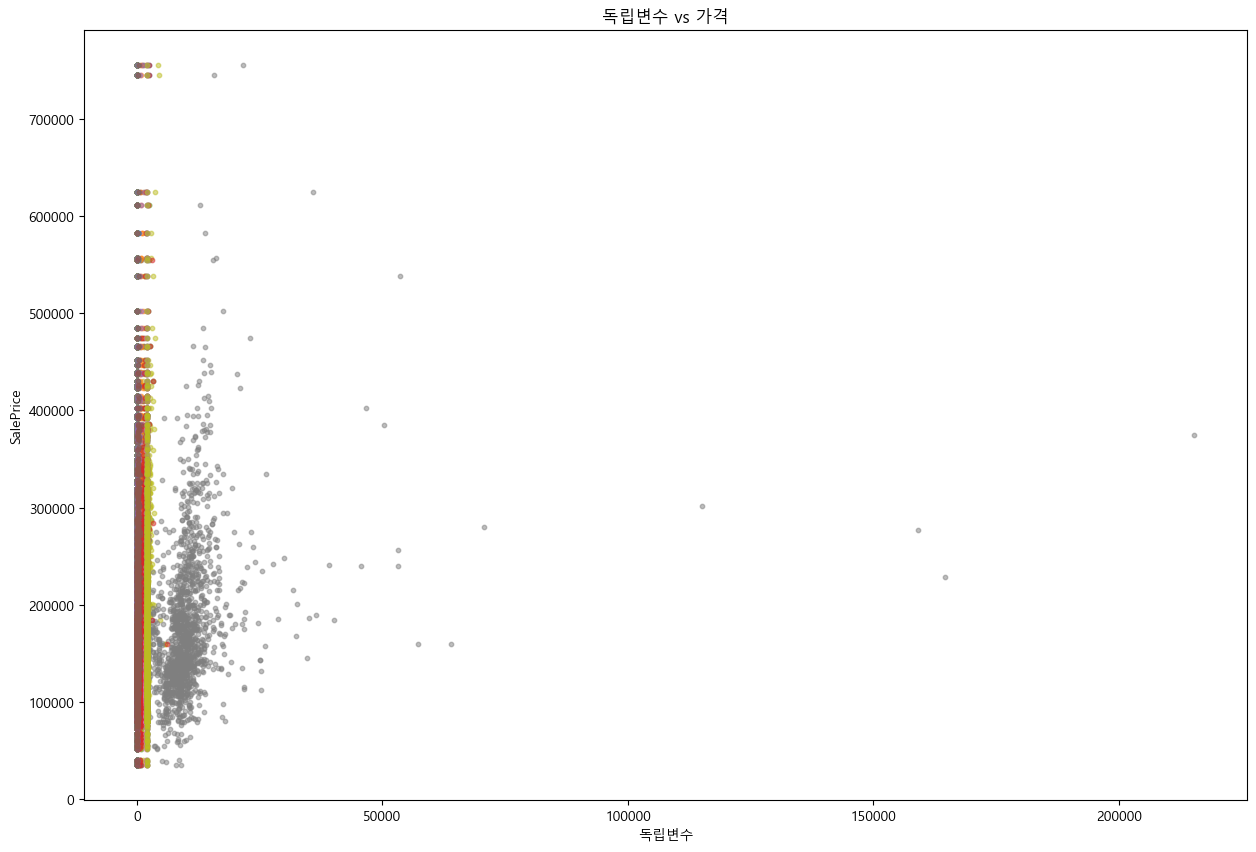

In [15]:
plt.figure(figsize=(15, 10))
for col in df.columns.difference(["SalePrice"]):
    plt.scatter(df[col], df["SalePrice"], alpha=0.5, label=col, s=10)

plt.xlabel("독립변수")
plt.ylabel("SalePrice")
plt.title("독립변수 vs 가격")
plt.show()
# <해석>
# 비선형적인 그래프가 보이고 있으며,
# 피어슨 상관계수는 주로 선형 형태에서 사용되는 방법이기에 
# 선형 또는 비선형 관계를 모두 포함하여 검정 가능한 스피어만 상관계수를 사용하였음.

In [16]:
indep_column = x.columns
spearmanr(x[indep_column[0]],y)

SignificanceResult(statistic=0.007192252911733476, pvalue=0.7836360376210691)

In [17]:
for i in indep_column :
    s, p = spearmanr(x[i],y)
    i_msg = "유의미 하지 않음"

    if p < 0.05 :
        i_msg = "유의미 함"

    msg = f"""
        독립변수({i})와 종속변수(가격)의 상관관계 계수는 {s:.3f}이고,
        p-value의 값은 {p}임. 따라서 p-value < 0.05에 대하여 {i_msg}
    """
    print(msg)


        독립변수(MSSubClass)와 종속변수(가격)의 상관관계 계수는 0.007이고,
        p-value의 값은 0.7836360376210691임. 따라서 p-value < 0.05에 대하여 유의미 하지 않음
    

        독립변수(MSZoning)와 종속변수(가격)의 상관관계 계수는 -0.335이고,
        p-value의 값은 1.3404710391422381e-39임. 따라서 p-value < 0.05에 대하여 유의미 함
    

        독립변수(LotFrontage)와 종속변수(가격)의 상관관계 계수는 0.385이고,
        p-value의 값은 1.1882779562904924e-52임. 따라서 p-value < 0.05에 대하여 유의미 함
    

        독립변수(LotArea)와 종속변수(가격)의 상관관계 계수는 0.456이고,
        p-value의 값은 4.8715809571702074e-76임. 따라서 p-value < 0.05에 대하여 유의미 함
    

        독립변수(Street)와 종속변수(가격)의 상관관계 계수는 0.046이고,
        p-value의 값은 0.08012225427616039임. 따라서 p-value < 0.05에 대하여 유의미 하지 않음
    

        독립변수(Alley)와 종속변수(가격)의 상관관계 계수는 -0.122이고,
        p-value의 값은 2.7936050827477304e-06임. 따라서 p-value < 0.05에 대하여 유의미 함
    

        독립변수(LotShape)와 종속변수(가격)의 상관관계 계수는 -0.306이고,
        p-value의 값은 5.267024377311837e-33임. 따라서 p-value < 0.05에 대하여 유의미 함
    

        독립변수(LandContour)와 종속변수(가격)의 상관관계 계수는 -0.010이고,
        p-

<Axes: >

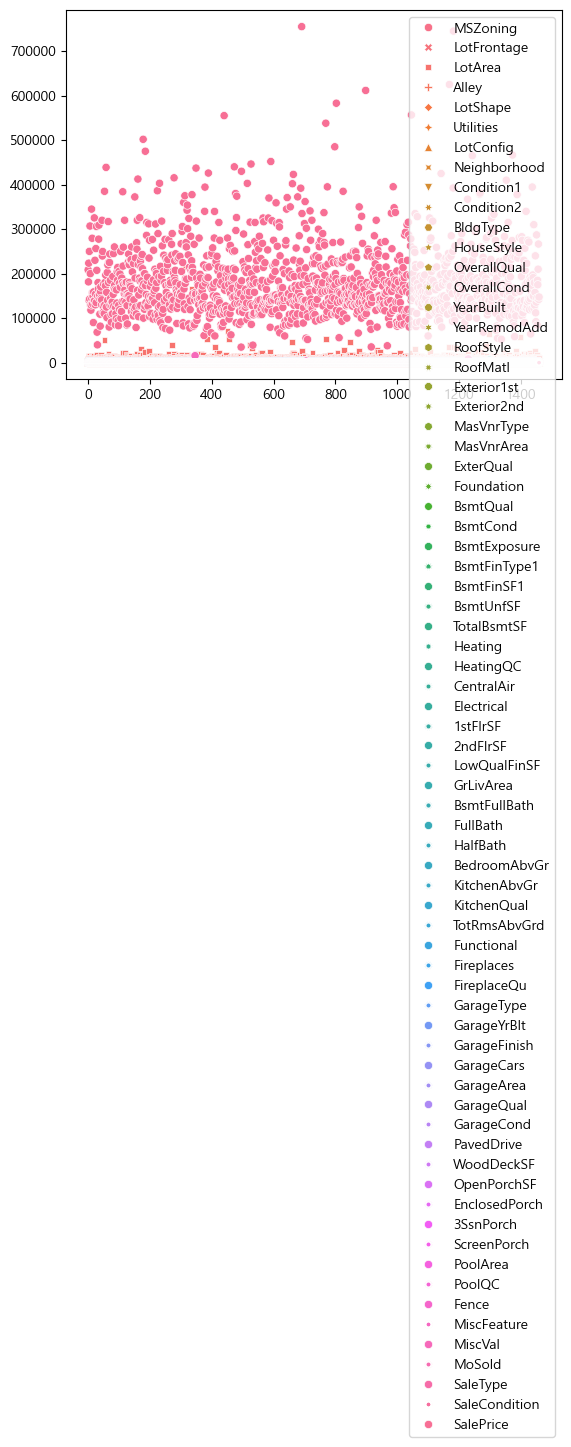

In [18]:
 ### spearmanr에서 유의미하지 않은 컬럼
 # MSSubClass, Street, LandContour, Utilities, LandSlope, ExterCond, BsmtFinType2, BsmtFinSF2, BsmtHalfBath, YrSold 10개 컬럼

df_fillter_spearmanr = df.drop(columns=["MSSubClass","Street","LandContour","LandSlope", "ExterCond", "BsmtFinType2", "BsmtFinSF2", "BsmtHalfBath", "YrSold"])
df_fillter_spearmanr
sns.scatterplot(df_fillter_spearmanr) # 비선형적인 그래프

In [19]:
correlation_matrix = df_fillter_spearmanr.corr()
# correlation_matrix
saleprice_corr = correlation_matrix["SalePrice"].abs()
saleprice_corr.sort_values(ascending=True)

Condition2      0.007513
Utilities       0.014314
MiscVal         0.021190
LowQualFinSF    0.025606
3SsnPorch       0.044584
                  ...   
GarageCars      0.640409
ExterQual       0.682639
GrLivArea       0.708624
OverallQual     0.790982
SalePrice       1.000000
Name: SalePrice, Length: 71, dtype: float64

### 스피어만 상관계수에서 특성중요도 도출

In [20]:
x_spearmanr= df_fillter_spearmanr.drop(columns=["SalePrice"])
y_spearmanr = df_fillter_spearmanr["SalePrice"]
x_train, x_temp, y_train, y_temp = train_test_split(x_spearmanr, y_spearmanr, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

# print(x_train.shape, y_train.shape)
# print(x_val.shape, y_val.shape)
# print(x_test.shape, y_test.shape)

# (1168, 70) (1168,)
# (146, 70) (146,)
# (146, 70) (146,)

In [21]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(x_train, y_train)

y_pred = rf_model.predict(x_val)

mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Val MSE: {mse:.4f}")
print(f"Val R² Score: {r2:.4f}")

# 특성 중요도
feature_importance = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# 특성 중요도 출력
print(feature_importance)

Val MSE: 511517868.3275
Val R² Score: 0.9127
         Feature    Importance
12   OverallQual  5.553137e-01
38     GrLivArea  1.214236e-01
30   TotalBsmtSF  3.476516e-02
36      2ndFlrSF  3.447004e-02
28    BsmtFinSF1  2.899005e-02
..           ...           ...
37  LowQualFinSF  6.053342e-05
17      RoofMatl  5.997243e-05
66       MiscVal  5.989982e-05
65   MiscFeature  4.109454e-05
5      Utilities  5.990403e-08

[70 rows x 2 columns]


#### 전처리이후 스피어만 상관계수에서 차이

In [22]:
"""
<해석>                                              <해석>
                                                    모델 성능 평가
                                                    Val MSE: 549322240.9364
                                                    Val R² Score: 0.9062  모델의 예측력이 90.62을 의미하는 값으로 상당히 훈련이 잘된 것으로 판단됨
전처리 이전 데이터 중 상관관계가 높은 top 4            특성중요도 - 중요한 top 4
OverallQual     0.790982                            OverallQual     0.563296
GrLivArea       0.708624                            GrLivArea       0.124168
GarageCars      0.640409                            TotalBsmtSF     0.037689
GarageArea      0.623431                            2ndFlrSF        0.037295
                                                    

전처리 이전 데이터 중 상관관계가 낮은 top 4           특성중요도 - 중요하지 않은 top 4    
OverallCond     0.077856                            3SsnPorch       0.000533
MSSubClass      0.084284                            LowQualFinSF    0.000184
EnclosedPorch   0.128578                            MiscVal         0.000135
KitchenAbvGr    0.135907                            BsmtHalfBath    0.000116
================================================================================================================================================
<해석>                                              <해석>
                                                    모델 성능 평가
                                                    Val MSE: 522791700.3006
                                                    Val R² Score: 0.9108  모델의 예측력이 91.08을 의미하는 값으로 상당히 훈련이 잘된 것으로 판단됨
전처리 이후 데이터 중 상관관계가 높은 top 4            특성중요도 - 중요한 top 4
OverallQual     0.790982                            OverallQual     0.555236
GrLivArea       0.708624                            GrLivArea       0.120953
ExterQual       0.682639                            2ndFlrSF        0.034469
GarageCars      0.640409                            TotalBsmtSF     0.033958
                                                    

전처리 이후 데이터 중 상관관계가 낮은 top 4            특성중요도 - 중요하지 않은 top 4    
Condition2      0.007513                            Utilities       0.000000
BsmtFinSF2      0.011378                            Street          0.000003
Utilities       0.014314                            MiscVal         0.000033
LandContour     0.015453                            MiscFeature     0.000036
================================================================================================================================================
<해석>                                              <해석>
                                                    모델 성능 평가
                                                    Val MSE: 511517868.3275
                                                    Val R² Score: 0.9127  모델의 예측력이 91.27을 의미하는 값으로 상당히 훈련이 잘된 것으로 판단됨
스피어만 데이터 중 상관관계가 높은 top 4               특성중요도 - 중요한 top 4
OverallQual     0.790982                            OverallQual     0.55531
GrLivArea       0.708624                            GrLivArea       0.12142
ExterQual       0.682639                            TotalBsmtSF     0.03476
GarageCars      0.640409                            2ndFlrSF        0.03447


스피어만 데이터 중 상관관계가 낮은 top 4               특성중요도 - 중요하지 않은 top 4
Condition2      0.007513                            Utilities       0.0000000599
Utilities       0.014314                            MiscFeature     0.000041
MiscVal         0.021190                            MiscVal         0.0000599
LowQualFinSF    0.025606                            RoofMatl        0.0000599
"""


"""
<해석>
- 전처리를 통해 MSE가 549 → 522으로 줄어듦 → 즉, 평균적으로 예측 오차가 감소
    R² Score가 0.9062 → 0.9108로 증가 → 즉, 모델이 실제 집값을 더 잘 설명하였음, 스피어만 상관계수 사용 시 성능 최적화
    스피어만 데이터의 MSE가 가장 낮음 (511M) → 예측 오차가 가장 적음, R² Score가 0.9127로 가장 높음 → 즉, 설명력이 가장 뛰어남
 -- 전처리 후, ExterQual(외관 품질)이 새로운 중요한 변수로 포함됨
     전처리 이전에는 GarageArea(차고 면적)이 포함되었지만, 전처리 후 ExterQual(외관 품질)이 더 중요한 변수로 반영됨
     즉, 단순한 면적보다 외관 품질이 집값과 더 밀접한 관계가 있다는 것을 의미
     스피어만 데이터에서도 동일한 상관관계 유지
     스피어만 데이터를 적용했을 때도 ExterQual이 GarageArea보다 높은 중요도를 가짐
     이는 스피어만 상관계수가 비선형 관계까지 고려하여 좀 더 실제 가격과 관련된 변수를 잘 찾아냈을 가능성이 큼
 -- 전처리 후 불필요한 변수들이 정리됨
     BsmtFinSF2(지하실 마감 면적) 및 LandContour(토지 윤곽)가 제거됨, 
     대신, MiscVal(기타 값) 및 MiscFeature(기타 기능) 같은 중요도가 낮은 변수가 포함됨
     즉, 전처리를 통해 상대적으로 의미 없는 변수들이 정리되었다는 것을 의미, 스피어만 데이터에서도 불필요한 변수들이 유지되지만, 일부 조정됨
     LowQualFinSF(저품질 마감 면적) 및 RoofMatl(지붕 재료)가 추가됨, 이는 스피어만 방법이 변수 간 비선형 관계를 더 잘 반영한 결과일 가능성이 큼

 -- 가장 중요한 변수들은 거의 변함없음
     모든 경우에서 OverallQual(건축 품질)이 가장 중요한 변수, GrLivArea(거실 면적), TotalBsmtSF(지하실 면적), 2ndFlrSF(2층 면적)도 공통적으로 중요
     전처리 이후 변수 순위 변화
     전처리 이후 2ndFlrSF(2층 면적)의 중요도가 TotalBsmtSF보다 약간 높아짐, 이는 전처리를 통해 데이터가 정제되면서 변수 간 중요도가 조금씩 조정된 결과
     스피어만 데이터를 적용했을 때 큰 차이는 없지만, 중요도 값이 더 세밀하게 반영됨
     TotalBsmtSF와 2ndFlrSF의 중요도가 근소한 차이로 변화
     스피어만 데이터가 변수의 중요도를 조금 더 정밀하게 반영하는 효과를 보임


<의존성과 인과성 관련 인사이트 도출>
상관관계(피어슨 & 스피어만) 기반 변수 간 의존성 분석

(1) 전처리 이전 vs 이후 vs 스피어만 데이터에서 상관관계가 높은 변수
모든 데이터에서 OverallQual, GrLivArea 등은 집값(SalePrice)과 높은 상관관계를 가짐
전처리 후에는 ExterQual(외관 품질)이 추가됨 → 즉, 전처리를 통해 집값과 더 밀접한 변수가 반영됨
스피어만 데이터에서도 ExterQual이 유지됨 → 즉, 비선형 관계까지 고려해도 이 변수는 여전히 중요한 변수임

(2) 상관관계가 낮은 변수
Condition2, Utilities, MiscVal 등은 상관관계가 낮거나 거의 없음
전처리 후에도 여전히 중요도가 낮은 변수들은 유지됨
즉, 집값과 상관이 없는 변수들은 지속적으로 낮은 중요도를 가짐 → 제거해도 모델 성능에는 큰 영향을 주지 않음
"""

'\n<해석>\n- 전처리를 통해 MSE가 549 → 522으로 줄어듦 → 즉, 평균적으로 예측 오차가 감소\n    R² Score가 0.9062 → 0.9108로 증가 → 즉, 모델이 실제 집값을 더 잘 설명하였음, 스피어만 상관계수 사용 시 성능 최적화\n    스피어만 데이터의 MSE가 가장 낮음 (511M) → 예측 오차가 가장 적음, R² Score가 0.9127로 가장 높음 → 즉, 설명력이 가장 뛰어남\n -- 전처리 후, ExterQual(외관 품질)이 새로운 중요한 변수로 포함됨\n     전처리 이전에는 GarageArea(차고 면적)이 포함되었지만, 전처리 후 ExterQual(외관 품질)이 더 중요한 변수로 반영됨\n     즉, 단순한 면적보다 외관 품질이 집값과 더 밀접한 관계가 있다는 것을 의미\n     스피어만 데이터에서도 동일한 상관관계 유지\n     스피어만 데이터를 적용했을 때도 ExterQual이 GarageArea보다 높은 중요도를 가짐\n     이는 스피어만 상관계수가 비선형 관계까지 고려하여 좀 더 실제 가격과 관련된 변수를 잘 찾아냈을 가능성이 큼\n -- 전처리 후 불필요한 변수들이 정리됨\n     BsmtFinSF2(지하실 마감 면적) 및 LandContour(토지 윤곽)가 제거됨, \n     대신, MiscVal(기타 값) 및 MiscFeature(기타 기능) 같은 중요도가 낮은 변수가 포함됨\n     즉, 전처리를 통해 상대적으로 의미 없는 변수들이 정리되었다는 것을 의미, 스피어만 데이터에서도 불필요한 변수들이 유지되지만, 일부 조정됨\n     LowQualFinSF(저품질 마감 면적) 및 RoofMatl(지붕 재료)가 추가됨, 이는 스피어만 방법이 변수 간 비선형 관계를 더 잘 반영한 결과일 가능성이 큼\n\n -- 가장 중요한 변수들은 거의 변함없음\n     모든 경우에서 OverallQual(건축 품질)이 가장 중요한 변수, GrLivArea(거실 면적), TotalBsmtSF(지하실 면

In [23]:
"""
(왜 하는지 궁금하면,,,)
처음엔 전체 데이터에서 상관계수와 중요도를 확인하고, 의미 없는 특성을 제거한 후 다시 분석하는 이유는,

필요 없는 특성을 제외하여 모델 성능을 높이고, 해석력을 개선하기 위해서
원본 분석은 전체적인 특성 중요도와 관계 파악,
스피어만 상관분석은 불필요한 특성을 제거한 후 다시 특성 간 관계를 정리하여 최적의 변수 선택하는 과정
"""

'\n(왜 하는지 궁금하면,,,)\n처음엔 전체 데이터에서 상관계수와 중요도를 확인하고, 의미 없는 특성을 제거한 후 다시 분석하는 이유는,\n\n필요 없는 특성을 제외하여 모델 성능을 높이고, 해석력을 개선하기 위해서\n원본 분석은 전체적인 특성 중요도와 관계 파악,\n스피어만 상관분석은 불필요한 특성을 제거한 후 다시 특성 간 관계를 정리하여 최적의 변수 선택하는 과정\n'

NameError: name 'SCA' is not defined